In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/enz-eff-project
!pip install -r requirements_final.txt

/content/drive/.shortcut-targets-by-id/1iS6gSWfUE3cZnmrNWbbV9_W_zQH3vaiu/enz-eff-project
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 551.9/551.9 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 84.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 kB 21.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 99.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.2/101.2 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7

# CNN

In [3]:
%cd /content/drive/MyDrive/enz-eff-project/improved_code/model_training

import random
random.seed(42)  # define seed

import numpy as np
np.random.seed(42)  # define seed

import tensorflow as tf
tf.random.set_seed(42)  # define seed

# Reduce randomness due the GPU manipulation
tf.config.experimental.enable_tensor_float_32_execution(False)
tf.config.optimizer.set_jit(False)
tf.config.experimental.list_physical_devices('GPU')

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Set to the desired GPU device
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
import warnings
warnings.filterwarnings("ignore")
import gc
import keras
keras.utils.set_random_seed(42)
import pandas as pd
from os.path import join
from tensorflow import keras
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import save_model
from tensorflow.keras.initializers import glorot_normal
from tensorflow import keras
from scipy.optimize import minimize
from utils import (get_processed_data,
                   create_model,
                   save_best_params,
                   is_not_require_params,
                   train_model,
                   calculate_weighted_mean,
                   evaluate_model,
                   get_model_preds,
                   delete_file,
                   empty_directory,
                   )


/content/drive/.shortcut-targets-by-id/1iS6gSWfUE3cZnmrNWbbV9_W_zQH3vaiu/enz-eff-project/improved_code/model_training


In [4]:
data_train = pd.read_pickle(
    join("..", "..", "data", "kcat_data", "splits", "train_df_kcat_new_feats.pkl")
)
data_test = pd.read_pickle(
    join("..", "..", "data", "kcat_data", "splits", "test_df_kcat_new_feats.pkl")
)

In [ ]:
def find_best_hyperparameter(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    best_model_path,
    best_hyperparameter_path,
    total_iterations=100,
    skip_iterations=0,

):
    """
    This function performs hyperparameter tuning.

    Parameters:
    train_inputs (numpy array): training input data
    test_inputs (numpy array): testing input data
    train_output (numpy array): training output data
    test_output (numpy array): testing output data
    best_model_path (string): path to save the best model
    best_hyperparameter_path (string): path to save the best hyperparameters

    Returns:
    best_hyperparameter (dict): Dictionary of best hyperparameter.

    """
    # Process train and test dataset
    train_X, train_Y = get_processed_data(train_inputs, train_output)
    test_X, test_Y = get_processed_data(test_inputs, test_output)
    n_timesteps, n_features = train_X.shape[1], train_X.shape[2]

    # Define the hyperparameter search space
    PARAM_SPACE = {
        "filters_1": list(range(2, 15, 2)),
        "filters_2": list(range(4, 25, 2)),
        "filters_3": list(range(8, 35, 2)),
        "kernel_size_1": list(range(3, 19, 2)),
        "kernel_size_2": list(range(5, 17, 2)),
        "kernel_size_3": list(range(7, 15, 2)),
        "dense_units_1": [64, 128, 256, 512],
        "dense_units_2": [8, 16, 32, 64, 128, 256],
        "dropout_rate": [0.10, 0.2, 0.3, 0.4, 0.5],
        "optimizer": ["nadam", "adam", "rmsprop"],
        "batch_size": [8, 16, 24, 32, 64, 128],
    }

    # To avoid processing duplicate parameters
    processed_params = []
    best_r2 = 0
    best_hyper_params = None
    iteration = 0

    while iteration < total_iterations:
        # Randomly select parameters from the parameter space
        hyper_params = {
            key: np.random.choice(value) for key, value in PARAM_SPACE.items()
        }

        # Skip if parameters are already processed or not required
        if hyper_params in processed_params or is_not_require_params(hyper_params):
            continue

        iteration += 1
        # Mark parameters as processed
        processed_params.append(hyper_params)

        if iteration < skip_iterations:
            continue

        print(f"Iteration-{iteration}...")

        # Create and train model
        model = create_model(n_timesteps, n_features, **hyper_params)
        model = train_model(model, train_X, train_Y, test_X, test_Y, hyper_params)
        y_pred = model.predict(test_X).reshape(-1)
        curr_r2 = round(r2_score(test_Y, y_pred), 2)

        # Update best parameters if current R2 score is better
        if curr_r2 > best_r2:
            best_r2, best_hyper_params = curr_r2, hyper_params
            save_best_params(best_hyperparameter_path, best_hyper_params, best_r2)
            # save_model(model, best_model_path)
            print(f"New best R2 score: {best_r2}")
            print(f"New Best hyperparameters: {best_hyper_params}")




    print("Hyperparameter tuning completed.")
    return best_hyper_params


In [ ]:
def start_model_training(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    total_models,
    hyper_params,
    model_dir="../../models/train_models/convolution/"
):
    """
    Train multiple models, create an ensemble, and evaluate its performance.

    Parameters:
        train_inputs (list): List of training input data.
        test_inputs (list): List of testing input data.
        train_output (numpy.ndarray): Training output data.
        test_output (numpy.ndarray): Testing output data.
        total_models (int): Total number of models to train.
        model_dir (str): Path to the directory containing trained models.
        hyper_params (dict): Dictionary containing hyperparameters for model training.

    Returns:
        tuple: A tuple containing weighted average predictions and ensemble output.
            - weighted_avg_pred (numpy.ndarray): Weighted average predictions.
            - ensemble_output (float): Ensemble output evaluation result.
    """
    # Process train and test dataset
    train_X, train_Y = get_processed_data(train_inputs, train_output)
    test_X, test_Y = get_processed_data(test_inputs, test_output)
    n_timesteps, n_features = train_X.shape[1], train_X.shape[2]

    # Getting the CNN model architecture
    model = create_model(n_timesteps, n_features, **hyper_params)

    # Train and get model predictions
    model_preds = get_model_preds(
        model_dir, hyper_params, total_models, model, train_X, train_Y, test_X, test_Y
    )

    # Calculate weighted mean model predictions
    weighted_avg_pred = calculate_weighted_mean(model_preds, test_Y)
    # print("Weighted Average Predictions: ", weighted_avg_pred)

    # Output predictions
    ensemble_output = evaluate_model(weighted_avg_pred, test_Y)
    print(f"Model score: {ensemble_output}")

    return weighted_avg_pred

## ESM1b_ts

### Hyperparameter tuning

In [ ]:
best_model_path = "../../models/hyperparam_tune_models/cnn_esm1bts.h5"
best_hyperparameter_path = "../../hyperparameters/esm1bts.txt"


# apply processing on train and test dataset
train_inputs = [data_train["ESM1b_ts_norm"],]
test_inputs = [data_test["ESM1b_ts_norm"],]


train_output = data_train["log10_kcat_norm"]
test_output = data_test["log10_kcat_norm"]


best_hyperparameters = find_best_hyperparameter(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    best_model_path,
    best_hyperparameter_path,
    total_iterations=50,
    skip_iterations=0
)

Iteration-1...


KeyboardInterrupt: 

### Training

In [ ]:
train_inputs = [data_train["ESM1b_ts_norm"],]
test_inputs = [data_test["ESM1b_ts_norm"],]


train_output = data_train["log10_kcat_norm"]
test_output = data_test["log10_kcat_norm"]


total_models = 3


# 43 R2
hyper_params = {
    'filters_1': 2,
    'filters_2': 4,
    'filters_3': 24,
    'kernel_size_1': 7,
    'kernel_size_2': 15,
    'kernel_size_3': 7,
    'dense_units_1': 512,
    'dense_units_2': 128,
    'dropout_rate': 0.1,
    'optimizer': 'rmsprop',
    'batch_size': 128
    }


esm1bts_pred = start_model_training(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    total_models,
    hyper_params,
)

28/28 [==============================] - 0s 4ms/step
Model-1 results {'mse': 0.57, 'R2 score': 0.43, 'pearson coefficient': 0.66}
28/28 [==============================] - 0s 2ms/step
Model-2 results {'mse': 0.56, 'R2 score': 0.44, 'pearson coefficient': 0.66}
28/28 [==============================] - 0s 2ms/step
Model-3 results {'mse': 0.56, 'R2 score': 0.44, 'pearson coefficient': 0.66}
Model score: {'mse': 0.56, 'R2 score': 0.44, 'pearson coefficient': 0.66}


## ESM1b

### Hyperparameter tuning

In [ ]:
best_model_path = "../../models/hyperparam_tune_models/cnn_esm1b.h5"
best_hyperparameter_path = "../../hyperparameters/cnn_esm1b.txt"


# apply processing on train and test dataset
train_inputs = [data_train["ESM1b_norm"]]
test_inputs = [data_test["ESM1b_norm"]]


train_output = data_train["log10_kcat_norm"]
test_output = data_test["log10_kcat_norm"]


best_hyperparameters = find_best_hyperparameter(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    best_model_path,
    best_hyperparameter_path,
    total_iterations=50,
    skip_iterations=0
)

Iteration-1...
28/28 [==============================] - 0s 3ms/step
New best R2 score: 0.39
New Best hyperparameters: {'filters_1': 8, 'filters_2': 14, 'filters_3': 24, 'kernel_size_1': 3, 'kernel_size_2': 13, 'kernel_size_3': 7, 'dense_units_1': 256, 'dense_units_2': 8, 'dropout_rate': 0.4, 'optimizer': 'adam', 'batch_size': 16}
Iteration-2...
28/28 [==============================] - 0s 3ms/step
Iteration-3...
28/28 [==============================] - 0s 3ms/step
Iteration-4...
28/28 [==============================] - 0s 4ms/step
Iteration-5...
28/28 [==============================] - 0s 4ms/step
New best R2 score: 0.41
New Best hyperparameters: {'filters_1': 2, 'filters_2': 12, 'filters_3': 26, 'kernel_size_1': 3, 'kernel_size_2': 9, 'kernel_size_3': 11, 'dense_units_1': 512, 'dense_units_2': 8, 'dropout_rate': 0.2, 'optimizer': 'rmsprop', 'batch_size': 128}
Iteration-6...
28/28 [==============================] - 0s 3ms/step
Iteration-7...
28/28 [==============================] - 0s 3

### Training

In [ ]:
train_inputs = [data_train["ESM1b_norm"]]
test_inputs = [data_test["ESM1b_norm"]]


train_output = data_train["log10_kcat_norm"]
test_output = data_test["log10_kcat_norm"]


total_models = 3

# 42 r2 score
hyper_params =  {'filters_1': 8, 'filters_2': 24, 'filters_3': 28, 'kernel_size_1': 3, 'kernel_size_2': 13, 'kernel_size_3': 7, 'dense_units_1': 128, 'dense_units_2': 8, 'dropout_rate': 0.1, 'optimizer': 'rmsprop', 'batch_size': 32}



esm1b_pred = start_model_training(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    total_models,
    hyper_params,
)



28/28 [==============================] - 0s 2ms/step
Model-1 results {'mse': 0.58, 'R2 score': 0.42, 'pearson coefficient': 0.65}
28/28 [==============================] - 0s 2ms/step
Model-2 results {'mse': 0.57, 'R2 score': 0.43, 'pearson coefficient': 0.66}
28/28 [==============================] - 0s 2ms/step
Model-3 results {'mse': 0.57, 'R2 score': 0.43, 'pearson coefficient': 0.65}
Model score: {'mse': 0.57, 'R2 score': 0.43, 'pearson coefficient': 0.66}


## DRFP

### Hyperparameter tuning

In [ ]:
best_model_path = "../../models/hyperparam_tune_models/cnn_drfp.h5"
best_hyperparameter_path = "../../hyperparameters/cnn_drfp.txt"


# apply processing on train and test dataset
train_inputs = [data_train["DRFP"]]
test_inputs = [data_test["DRFP"]]


train_output = data_train["log10_kcat_norm"]
test_output = data_test["log10_kcat_norm"]


best_hyperparameters = find_best_hyperparameter(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    best_model_path,
    best_hyperparameter_path,
    total_iterations=50,
    skip_iterations=0
)

Iteration-1...
28/28 [==============================] - 0s 3ms/step
New best R2 score: 0.36
New Best hyperparameters: {'filters_1': 6, 'filters_2': 8, 'filters_3': 26, 'kernel_size_1': 13, 'kernel_size_2': 13, 'kernel_size_3': 13, 'dense_units_1': 256, 'dense_units_2': 128, 'dropout_rate': 0.2, 'optimizer': 'nadam', 'batch_size': 8}
Iteration-2...
28/28 [==============================] - 0s 4ms/step
Iteration-3...
28/28 [==============================] - 0s 4ms/step
Iteration-4...
28/28 [==============================] - 0s 4ms/step
Iteration-5...
28/28 [==============================] - 0s 4ms/step
Iteration-6...
28/28 [==============================] - 0s 3ms/step
Iteration-7...
28/28 [==============================] - 0s 3ms/step
Iteration-8...
28/28 [==============================] - 0s 3ms/step
Iteration-9...
28/28 [==============================] - 0s 3ms/step
Iteration-10...
28/28 [==============================] - 0s 4ms/step
Iteration-11...
28/28 [=============================

### Training

In [ ]:
train_inputs = [data_train["DRFP"]]
test_inputs = [data_test["DRFP"]]

train_output = data_train["log10_kcat_norm"]
test_output = data_test["log10_kcat_norm"]


total_models = 3

#  38 r2
hyper_params = {'filters_1': 8, 'filters_2': 8, 'filters_3': 24, 'kernel_size_1': 17, 'kernel_size_2': 5, 'kernel_size_3': 11, 'dense_units_1': 128, 'dense_units_2': 8, 'dropout_rate': 0.4, 'optimizer': 'nadam', 'batch_size': 8}



drfp_pred = start_model_training(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    total_models,
    hyper_params,
)


28/28 [==============================] - 0s 3ms/step
Model-1 results {'mse': 0.62, 'R2 score': 0.38, 'pearson coefficient': 0.61}
28/28 [==============================] - 0s 4ms/step
Model-2 results {'mse': 0.62, 'R2 score': 0.38, 'pearson coefficient': 0.62}
28/28 [==============================] - 0s 2ms/step
Model-3 results {'mse': 0.63, 'R2 score': 0.37, 'pearson coefficient': 0.61}
Model score: {'mse': 0.62, 'R2 score': 0.38, 'pearson coefficient': 0.62}


## Difference_fp

### Hyperparameter tuning

In [ ]:
best_model_path = "../../models/hyperparam_tune_models/cnn_diff.h5"
best_hyperparameter_path = "../../hyperparameters/cnn_diff.txt"


# apply processing on train and test dataset
train_inputs = [data_train["difference_fp"]]
test_inputs = [data_test["difference_fp"]]


train_output = data_train["log10_kcat_norm"]
test_output = data_test["log10_kcat_norm"]


best_hyperparameters = find_best_hyperparameter(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    best_model_path,
    best_hyperparameter_path,
    total_iterations=50,
    skip_iterations=0
)

Iteration-1...
28/28 [==============================] - 0s 3ms/step
New best R2 score: 0.33
New Best hyperparameters: {'filters_1': 8, 'filters_2': 14, 'filters_3': 24, 'kernel_size_1': 3, 'kernel_size_2': 13, 'kernel_size_3': 7, 'dense_units_1': 256, 'dense_units_2': 8, 'dropout_rate': 0.4, 'optimizer': 'adam', 'batch_size': 16}
Iteration-2...
28/28 [==============================] - 0s 3ms/step
Iteration-3...
28/28 [==============================] - 0s 5ms/step
New best R2 score: 0.36
New Best hyperparameters: {'filters_1': 6, 'filters_2': 10, 'filters_3': 14, 'kernel_size_1': 5, 'kernel_size_2': 9, 'kernel_size_3': 11, 'dense_units_1': 64, 'dense_units_2': 64, 'dropout_rate': 0.3, 'optimizer': 'adam', 'batch_size': 16}
Iteration-4...
28/28 [==============================] - 0s 3ms/step
New best R2 score: 0.38
New Best hyperparameters: {'filters_1': 12, 'filters_2': 14, 'filters_3': 22, 'kernel_size_1': 15, 'kernel_size_2': 7, 'kernel_size_3': 9, 'dense_units_1': 256, 'dense_units_2'

### Training

In [ ]:
train_inputs = [data_train["difference_fp"]]
test_inputs = [data_test["difference_fp"]]

train_output = data_train["log10_kcat_norm"]
test_output = data_test["log10_kcat_norm"]


total_models = 3

# R2 score: 0.39
hyper_params = {'filters_1': 10, 'filters_2': 12, 'filters_3': 18, 'kernel_size_1': 15, 'kernel_size_2': 5, 'kernel_size_3': 7, 'dense_units_1': 256, 'dense_units_2': 64, 'dropout_rate': 0.2, 'optimizer': 'nadam', 'batch_size': 64}



diff_pred = start_model_training(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    total_models,
    hyper_params,
)


28/28 [==============================] - 0s 4ms/step
Model-1 results {'mse': 0.61, 'R2 score': 0.39, 'pearson coefficient': 0.62}
28/28 [==============================] - 0s 3ms/step
Model-2 results {'mse': 0.61, 'R2 score': 0.39, 'pearson coefficient': 0.62}
28/28 [==============================] - 0s 3ms/step
Model-3 results {'mse': 0.62, 'R2 score': 0.38, 'pearson coefficient': 0.61}
Model score: {'mse': 0.61, 'R2 score': 0.39, 'pearson coefficient': 0.62}


## structural_fp

### Hyperparameter tuning

In [ ]:
best_model_path = "../../models/hyperparam_tune_models/cnn_struct.h5"
best_hyperparameter_path = "../../hyperparameters/cnn_struct.txt"


# apply processing on train and test dataset
train_inputs = [data_train["structural_fp"]]
test_inputs = [data_test["structural_fp"]]


train_output = data_train["log10_kcat_norm"]
test_output = data_test["log10_kcat_norm"]


best_hyperparameters = find_best_hyperparameter(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    best_model_path,
    best_hyperparameter_path,
    total_iterations=50,
    skip_iterations=0
)

Iteration-1...
28/28 [==============================] - 0s 3ms/step
New best R2 score: 0.33
New Best hyperparameters: {'filters_1': 6, 'filters_2': 22, 'filters_3': 30, 'kernel_size_1': 9, 'kernel_size_2': 15, 'kernel_size_3': 9, 'dense_units_1': 256, 'dense_units_2': 256, 'dropout_rate': 0.3, 'optimizer': 'rmsprop', 'batch_size': 32}
Iteration-2...
28/28 [==============================] - 0s 3ms/step
Iteration-3...
28/28 [==============================] - 0s 3ms/step
Iteration-4...
28/28 [==============================] - 0s 5ms/step
Iteration-5...
28/28 [==============================] - 0s 4ms/step
New best R2 score: 0.35
New Best hyperparameters: {'filters_1': 8, 'filters_2': 10, 'filters_3': 34, 'kernel_size_1': 11, 'kernel_size_2': 13, 'kernel_size_3': 11, 'dense_units_1': 256, 'dense_units_2': 128, 'dropout_rate': 0.4, 'optimizer': 'nadam', 'batch_size': 24}
Iteration-6...
28/28 [==============================] - 0s 3ms/step
New best R2 score: 0.36
New Best hyperparameters: {'fi

### Training

In [ ]:
train_inputs = [data_train["structural_fp"]]
test_inputs = [data_test["structural_fp"]]

train_output = data_train["log10_kcat_norm"]
test_output = data_test["log10_kcat_norm"]


total_models = 3

# R2 score: 0.38
hyper_params = {'filters_1': 8, 'filters_2': 12, 'filters_3': 18, 'kernel_size_1': 11, 'kernel_size_2': 9, 'kernel_size_3': 13, 'dense_units_1': 64, 'dense_units_2': 64, 'dropout_rate': 0.3, 'optimizer': 'rmsprop', 'batch_size': 32}


struct_pred = start_model_training(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    total_models,
    hyper_params,
)


28/28 [==============================] - 0s 3ms/step
Model-1 results {'mse': 0.62, 'R2 score': 0.38, 'pearson coefficient': 0.62}
28/28 [==============================] - 0s 3ms/step
Model-2 results {'mse': 0.64, 'R2 score': 0.36, 'pearson coefficient': 0.6}
28/28 [==============================] - 0s 4ms/step
Model-3 results {'mse': 0.64, 'R2 score': 0.36, 'pearson coefficient': 0.6}
Model score: {'mse': 0.62, 'R2 score': 0.38, 'pearson coefficient': 0.62}


## ESM1b *  ESM1b_ts

### Hyperparameter tuning

In [ ]:
best_model_path = "../../models/hyperparam_tune_models/esm_combined.h5"
best_hyperparameter_path = "../../hyperparameters/esm_combined.txt"


# apply processing on train and test dataset
train_inputs = [
    data_train["ESM1b_norm"]*data_train["ESM1b_ts_norm"],
]

test_inputs = [
    data_test["ESM1b_norm"] * data_test["ESM1b_ts_norm"],
]


train_output = data_train["log10_kcat_norm"]
test_output = data_test["log10_kcat_norm"]


best_hyperparameters = find_best_hyperparameter(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    best_model_path,
    best_hyperparameter_path,
    total_iterations=50,
    skip_iterations=0
)

Iteration-1...
28/28 [==============================] - 0s 3ms/step
New best R2 score: 0.41
New Best hyperparameters: {'filters_1': 6, 'filters_2': 22, 'filters_3': 30, 'kernel_size_1': 9, 'kernel_size_2': 15, 'kernel_size_3': 9, 'dense_units_1': 256, 'dense_units_2': 256, 'dropout_rate': 0.3, 'optimizer': 'rmsprop', 'batch_size': 32}
Iteration-2...
28/28 [==============================] - 0s 3ms/step
Iteration-3...
28/28 [==============================] - 0s 4ms/step
Iteration-4...
28/28 [==============================] - 0s 3ms/step
New best R2 score: 0.44
New Best hyperparameters: {'filters_1': 14, 'filters_2': 24, 'filters_3': 24, 'kernel_size_1': 15, 'kernel_size_2': 7, 'kernel_size_3': 9, 'dense_units_1': 512, 'dense_units_2': 128, 'dropout_rate': 0.3, 'optimizer': 'rmsprop', 'batch_size': 8}
Iteration-5...
28/28 [==============================] - 0s 3ms/step
Iteration-6...
28/28 [==============================] - 0s 2ms/step
Iteration-7...
28/28 [==============================] 

### Training

In [ ]:
# apply processing on train and test dataset
train_inputs = [
    data_train["ESM1b_norm"] * data_train["ESM1b_ts_norm"],
]

test_inputs = [
    data_test["ESM1b_norm"] * data_test["ESM1b_ts_norm"],
]


train_output = data_train["log10_kcat_norm"]
test_output = data_test["log10_kcat_norm"]


total_models = 3

hyper_params = {
    "filters_1": 14,
    "filters_2": 24,
    "filters_3": 24,
    "kernel_size_1": 15,
    "kernel_size_2": 7,
    "kernel_size_3": 9,
    "dense_units_1": 512,
    "dense_units_2": 128,
    "dropout_rate": 0.3,
    "optimizer": "rmsprop",
    "batch_size": 8,
}


esm_combined = start_model_training(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    total_models,
    hyper_params,
)

28/28 [==============================] - 0s 3ms/step
Model-1 results {'mse': 0.56, 'R2 score': 0.44, 'pearson coefficient': 0.66}
28/28 [==============================] - 0s 2ms/step
Model-2 results {'mse': 0.56, 'R2 score': 0.44, 'pearson coefficient': 0.66}
28/28 [==============================] - 0s 2ms/step
Model-3 results {'mse': 0.56, 'R2 score': 0.44, 'pearson coefficient': 0.66}
Model score: {'mse': 0.55, 'R2 score': 0.45, 'pearson coefficient': 0.67}


## ESM1b + DRFP

### Hyperparameter tuning

In [ ]:
best_model_path = "../../models/hyperparam_tune_models/esm1b_drfp.h5"
best_hyperparameter_path = "../../hyperparameters/esm1b_drfp.txt"

# apply processing on train and test dataset
train_inputs = [
    data_train["DRFP"],
    data_train["ESM1b_norm"],
]

test_inputs = [
    data_test["DRFP"],
    data_test["ESM1b_norm"],
]

train_output = data_train["log10_kcat_norm"]
test_output = data_test["log10_kcat_norm"]


best_hyperparameters = find_best_hyperparameter(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    best_model_path,
    best_hyperparameter_path,
    total_iterations=60
)


Iteration-1...
27/27 [==============================] - 1s 4ms/step
New best R2 score: 0.4
New Best hyperparameters: {'filters_1': 6, 'filters_2': 22, 'filters_3': 30, 'kernel_size_1': 9, 'kernel_size_2': 15, 'kernel_size_3': 9, 'dense_units_1': 256, 'dense_units_2': 256, 'dropout_rate': 0.3, 'optimizer': 'rmsprop', 'batch_size': 32}
Iteration-2...
27/27 [==============================] - 0s 3ms/step
Iteration-3...
27/27 [==============================] - 0s 2ms/step
New best R2 score: 0.42
New Best hyperparameters: {'filters_1': 6, 'filters_2': 8, 'filters_3': 8, 'kernel_size_1': 7, 'kernel_size_2': 13, 'kernel_size_3': 9, 'dense_units_1': 256, 'dense_units_2': 16, 'dropout_rate': 0.1, 'optimizer': 'rmsprop', 'batch_size': 8}
Iteration-4...
27/27 [==============================] - 0s 4ms/step
New best R2 score: 0.45
New Best hyperparameters: {'filters_1': 14, 'filters_2': 24, 'filters_3': 24, 'kernel_size_1': 15, 'kernel_size_2': 7, 'kernel_size_3': 9, 'dense_units_1': 512, 'dense_uni

### Training

In [ ]:
train_inputs = [
    data_train["DRFP"],
    data_train["ESM1b_norm"],
]

test_inputs = [
    data_test["DRFP"],
    data_test["ESM1b_norm"],
]
train_output = data_train["log10_kcat_norm"]
test_output = data_test["log10_kcat_norm"]


total_models = 3
# hyper_params = {'filters_1': 8, 'filters_2': 14, 'filters_3': 24, 'kernel_size_1': 13, 'kernel_size_2': 15, 'kernel_size_3': 13, 'dense_units_1': 512, 'dense_units_2': 64, 'dropout_rate': 0.1, 'optimizer': 'rmsprop', 'batch_size': 32}

hyper_params = {
    "filters_1": 2,
    "filters_2": 6,
    "filters_3": 8,
    "kernel_size_1": 17,
    "kernel_size_2": 13,
    "kernel_size_3": 9,
    "dense_units_1": 512,
    "dense_units_2": 256,
    "dropout_rate": 0.2,
    "optimizer": "rmsprop",
    "batch_size": 24,
}

esm1b_drfp = start_model_training(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    total_models,
    hyper_params,
)


28/28 [==============================] - 0s 2ms/step
Model-1 results {'mse': 0.53, 'R2 score': 0.47, 'pearson coefficient': 0.68}
28/28 [==============================] - 0s 2ms/step
Model-2 results {'mse': 0.55, 'R2 score': 0.45, 'pearson coefficient': 0.67}
28/28 [==============================] - 0s 2ms/step
Model-3 results {'mse': 0.55, 'R2 score': 0.45, 'pearson coefficient': 0.67}
Model score: {'mse': 0.53, 'R2 score': 0.47, 'pearson coefficient': 0.68}


## ESM1b + Difference

### Hyperparameter optimization

In [ ]:
best_model_path = "../../models/hyperparam_tune_models/esm1b_diff.h5"
best_hyperparameter_path = "../../hyperparameters/esm1b_diff.txt"

# apply processing on train and test dataset
train_inputs = [
    data_train["difference_fp"],
    data_train["ESM1b_norm"],
]

test_inputs = [
    data_test["difference_fp"],
    data_test["ESM1b_norm"],
]

train_output = data_train["log10_kcat_norm"]
test_output = data_test["log10_kcat_norm"]


best_hyperparameters = find_best_hyperparameter(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    best_model_path,
    best_hyperparameter_path,
    total_iterations=60
)


Iteration-1...
27/27 [==============================] - 0s 4ms/step
New best R2 score: 0.35
New Best hyperparameters: {'filters_1': 6, 'filters_2': 8, 'filters_3': 8, 'kernel_size_1': 7, 'kernel_size_2': 13, 'kernel_size_3': 9, 'dense_units_1': 256, 'dense_units_2': 16, 'dropout_rate': 0.1, 'optimizer': 'rmsprop', 'batch_size': 8}
Iteration-2...
27/27 [==============================] - 0s 5ms/step
Iteration-3...
27/27 [==============================] - 0s 4ms/step
New best R2 score: 0.37
New Best hyperparameters: {'filters_1': 8, 'filters_2': 10, 'filters_3': 34, 'kernel_size_1': 11, 'kernel_size_2': 13, 'kernel_size_3': 11, 'dense_units_1': 256, 'dense_units_2': 128, 'dropout_rate': 0.4, 'optimizer': 'nadam', 'batch_size': 24}
Iteration-4...
27/27 [==============================] - 0s 3ms/step
New best R2 score: 0.41
New Best hyperparameters: {'filters_1': 6, 'filters_2': 14, 'filters_3': 30, 'kernel_size_1': 5, 'kernel_size_2': 7, 'kernel_size_3': 7, 'dense_units_1': 128, 'dense_unit

### Training

In [ ]:
# almost close the hyperparameter tuning results
train_inputs = [
    data_train["difference_fp"],
    data_train["ESM1b_norm"],
]

test_inputs = [
    data_test["difference_fp"],
    data_test["ESM1b_norm"],
]
train_output = data_train["log10_kcat_norm"]
test_output = data_test["log10_kcat_norm"]


total_models = 3
# hyper_params = {'filters_1': 2, 'filters_2': 4, 'filters_3': 12, 'kernel_size_1': 13, 'kernel_size_2': 7, 'kernel_size_3': 7, 'dense_units_1': 512, 'dense_units_2': 16, 'dropout_rate': 0.4, 'optimizer': 'rmsprop', 'batch_size': 24}
hyper_params = {'filters_1': 2, 'filters_2': 8, 'filters_3': 12, 'kernel_size_1': 17, 'kernel_size_2': 9, 'kernel_size_3': 13, 'dense_units_1': 512, 'dense_units_2': 256, 'dropout_rate': 0.1, 'optimizer': 'rmsprop', 'batch_size': 8}


esm1b_diff = start_model_training(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    total_models,
    hyper_params,
)


28/28 [==============================] - 0s 3ms/step
Model-1 results {'mse': 0.51, 'R2 score': 0.49, 'pearson coefficient': 0.7}
28/28 [==============================] - 0s 3ms/step
Model-2 results {'mse': 0.52, 'R2 score': 0.48, 'pearson coefficient': 0.69}
28/28 [==============================] - 0s 2ms/step
Model-3 results {'mse': 0.52, 'R2 score': 0.48, 'pearson coefficient': 0.69}
Model score: {'mse': 0.51, 'R2 score': 0.49, 'pearson coefficient': 0.7}


## ESM1b_ts + DRFP

### Hyperparameter optimization

In [ ]:
best_model_path = "../../models/hyperparam_tune_models/esm1bts_drfp.h5"
best_hyperparameter_path = "../../hyperparameters/esm1bts_drfp.txt"

# apply processing on train and test dataset
train_inputs = [
    data_train["DRFP"],
    data_train["ESM1b_ts_norm"],
]

test_inputs = [
    data_test["DRFP"],
    data_test["ESM1b_ts_norm"],
]

train_output = data_train["log10_kcat_norm"]
test_output = data_test["log10_kcat_norm"]


best_hyperparameters = find_best_hyperparameter(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    best_model_path,
    best_hyperparameter_path,
    total_iterations=60
)


### Training

In [ ]:
# almost close the hyperparameter tuning results
train_inputs = [
    data_train["DRFP"],
    data_train["ESM1b_ts_norm"],
]

test_inputs = [
    data_test["DRFP"],
    data_test["ESM1b_ts_norm"],
]
train_output = data_train["log10_kcat_norm"]
test_output = data_test["log10_kcat_norm"]


total_models = 3

# hyper_params = {'filters_1': 10, 'filters_2': 12, 'filters_3': 34, 'kernel_size_1': 13, 'kernel_size_2': 7, 'kernel_size_3': 9, 'dense_units_1': 256, 'dense_units_2': 64, 'dropout_rate': 0.1, 'optimizer': 'rmsprop', 'batch_size': 8}
hyper_params = {'filters_1': 12, 'filters_2': 22, 'filters_3': 28, 'kernel_size_1': 5, 'kernel_size_2': 5, 'kernel_size_3': 9, 'dense_units_1': 64, 'dense_units_2': 8, 'dropout_rate': 0.2, 'optimizer': 'rmsprop', 'batch_size': 128}

esm1bts_drfp = start_model_training(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    total_models,
    hyper_params,
)

28/28 [==============================] - 0s 5ms/step
Model-1 results {'mse': 0.53, 'R2 score': 0.47, 'pearson coefficient': 0.68}
28/28 [==============================] - 0s 3ms/step
Model-2 results {'mse': 0.54, 'R2 score': 0.46, 'pearson coefficient': 0.68}
28/28 [==============================] - 0s 3ms/step
Model-3 results {'mse': 0.54, 'R2 score': 0.46, 'pearson coefficient': 0.68}
Model score: {'mse': 0.53, 'R2 score': 0.47, 'pearson coefficient': 0.68}


## ESM1bts + Difference FP

### Hyperparameter optimization

In [ ]:
best_model_path = "../../models/hyperparam_tune_models/esm1bts_diff.h5"
best_hyperparameter_path = "../../hyperparameters/esm1bts_diff.txt"

# apply processing on train and test dataset
train_inputs = [
    data_train["difference_fp"],
    data_train["ESM1b_ts_norm"],
]

test_inputs = [
    data_test["difference_fp"],
    data_test["ESM1b_ts_norm"],
]

train_output = data_train["log10_kcat_norm"]
test_output = data_test["log10_kcat_norm"]


best_hyperparameters = find_best_hyperparameter(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    best_model_path,
    best_hyperparameter_path,
    total_iterations=60,
)


Iteration-1...
28/28 [==============================] - 0s 3ms/step
New best R2 score: 0.46
New Best hyperparameters: {'filters_1': 6, 'filters_2': 22, 'filters_3': 30, 'kernel_size_1': 9, 'kernel_size_2': 15, 'kernel_size_3': 9, 'dense_units_1': 256, 'dense_units_2': 256, 'dropout_rate': 0.3, 'optimizer': 'rmsprop', 'batch_size': 32}
Iteration-2...
28/28 [==============================] - 0s 3ms/step
Iteration-3...
28/28 [==============================] - 0s 4ms/step
Iteration-4...


### Training

In [ ]:
# almost close the hyperparameter tuning results
train_inputs = [
    data_train["difference_fp"],
    data_train["ESM1b_ts_norm"],
]

test_inputs = [

    data_test["difference_fp"],
    data_test["ESM1b_ts_norm"],
]
train_output = data_train["log10_kcat_norm"]
test_output = data_test["log10_kcat_norm"]


total_models = 3

# hyper_params = {'filters_1': 6, 'filters_2': 16, 'filters_3': 26, 'kernel_size_1': 11, 'kernel_size_2': 5, 'kernel_size_3': 11, 'dense_units_1': 256, 'dense_units_2': 8, 'dropout_rate': 0.5, 'optimizer': 'nadam', 'batch_size': 64}
hyper_params = {'filters_1': 2, 'filters_2': 8, 'filters_3': 12, 'kernel_size_1': 17, 'kernel_size_2': 9, 'kernel_size_3': 13, 'dense_units_1': 512, 'dense_units_2': 256, 'dropout_rate': 0.1, 'optimizer': 'rmsprop', 'batch_size': 8}


esm1bts_diff = start_model_training(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    total_models,
    hyper_params,
)

28/28 [==============================] - 0s 4ms/step
Model-1 results {'mse': 0.53, 'R2 score': 0.47, 'pearson coefficient': 0.68}
28/28 [==============================] - 0s 3ms/step
Model-2 results {'mse': 0.53, 'R2 score': 0.47, 'pearson coefficient': 0.68}
28/28 [==============================] - 0s 3ms/step
Model-3 results {'mse': 0.53, 'R2 score': 0.47, 'pearson coefficient': 0.68}
Model score: {'mse': 0.53, 'R2 score': 0.47, 'pearson coefficient': 0.69}


## ESM1b + Structural FP

### Hyperparameter Tuning

In [ ]:
best_model_path = "../../models/hyperparam_tune_models/esm1b_struct.h5"
best_hyperparameter_path = "../../hyperparameters/esm1b_struct.txt"

# apply processing on train and test dataset
train_inputs = [
    data_train["structural_fp"],
    data_train["ESM1b_norm"],
]

test_inputs = [
    data_test["structural_fp"],
    data_test["ESM1b_norm"],
]

train_output = data_train["log10_kcat_norm"]
test_output = data_test["log10_kcat_norm"]


best_hyperparameters = find_best_hyperparameter(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    best_model_path,
    best_hyperparameter_path,
    total_iterations=60,
    skip_iterations=0
)


Iteration-59...
27/27 [==============================] - 1s 7ms/step
New best R2 score: 0.39
New Best hyperparameters: {'filters_1': 4, 'filters_2': 4, 'filters_3': 34, 'kernel_size_1': 7, 'kernel_size_2': 7, 'kernel_size_3': 9, 'dense_units_1': 128, 'dense_units_2': 64, 'dropout_rate': 0.1, 'optimizer': 'adam', 'batch_size': 128}
Iteration-60...
27/27 [==============================] - 0s 4ms/step
Iteration-61...
27/27 [==============================] - 0s 4ms/step
Iteration-62...
27/27 [==============================] - 0s 5ms/step
New best R2 score: 0.4
New Best hyperparameters: {'filters_1': 4, 'filters_2': 14, 'filters_3': 30, 'kernel_size_1': 17, 'kernel_size_2': 5, 'kernel_size_3': 9, 'dense_units_1': 128, 'dense_units_2': 32, 'dropout_rate': 0.1, 'optimizer': 'adam', 'batch_size': 24}
Iteration-63...
27/27 [==============================] - 0s 4ms/step
New best R2 score: 0.42
New Best hyperparameters: {'filters_1': 2, 'filters_2': 20, 'filters_3': 22, 'kernel_size_1': 5, 'kerne

###Training

In [ ]:
# almost close the hyperparameter tuning results
train_inputs = [
    data_train["structural_fp"],
    data_train["ESM1b_norm"],
]

test_inputs = [

    data_test["structural_fp"],
    data_test["ESM1b_norm"],
]
train_output = data_train["log10_kcat_norm"]
test_output = data_test["log10_kcat_norm"]


total_models = 3
# hyper_params = {'filters_1': 10, 'filters_2': 20, 'filters_3': 20, 'kernel_size_1': 17, 'kernel_size_2': 7, 'kernel_size_3': 9, 'dense_units_1': 128, 'dense_units_2': 8, 'dropout_rate': 0.4, 'optimizer': 'nadam', 'batch_size': 32}
hyper_params = {'filters_1': 2, 'filters_2': 6, 'filters_3': 8, 'kernel_size_1': 17, 'kernel_size_2': 13, 'kernel_size_3': 9, 'dense_units_1': 512, 'dense_units_2': 256, 'dropout_rate': 0.2, 'optimizer': 'rmsprop', 'batch_size': 24}


esm1b_struct = start_model_training(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    total_models,
    hyper_params,
)

28/28 [==============================] - 0s 3ms/step
Model-1 results {'mse': 0.56, 'R2 score': 0.44, 'pearson coefficient': 0.66}
28/28 [==============================] - 0s 3ms/step
Model-2 results {'mse': 0.56, 'R2 score': 0.44, 'pearson coefficient': 0.66}
28/28 [==============================] - 0s 3ms/step
Model-3 results {'mse': 0.56, 'R2 score': 0.44, 'pearson coefficient': 0.66}
Model score: {'mse': 0.56, 'R2 score': 0.44, 'pearson coefficient': 0.66}


## ESM1b_ts + Structural FP

### Hyperparameter tuning

In [ ]:
best_model_path = "../../models/hyperparam_tune_models/esm1bts_struct.h5"
best_hyperparameter_path = "../../hyperparameters/esm1bts_struct.txt"


# apply processing on train and test dataset
train_inputs = [
    data_train["structural_fp"],
    data_train["ESM1b_ts_norm"],
]

test_inputs = [
    data_test["structural_fp"],
    data_test["ESM1b_ts_norm"],
]

train_output = data_train["log10_kcat_norm"]
test_output = data_test["log10_kcat_norm"]


best_hyperparameters = find_best_hyperparameter(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    best_model_path,
    best_hyperparameter_path,
    total_iterations=60,
    skip_iterations=0
)

Iteration-1...
28/28 [==============================] - 0s 5ms/step
New best R2 score: 0.38
New Best hyperparameters: {'filters_1': 6, 'filters_2': 22, 'filters_3': 30, 'kernel_size_1': 9, 'kernel_size_2': 15, 'kernel_size_3': 9, 'dense_units_1': 256, 'dense_units_2': 256, 'dropout_rate': 0.3, 'optimizer': 'rmsprop', 'batch_size': 32}
Iteration-2...


### Training

In [ ]:
# almost close the hyperparameter tuning results
train_inputs = [
    data_train["structural_fp"],
    data_train["ESM1b_ts_norm"],
]

test_inputs = [

    data_test["structural_fp"],
    data_test["ESM1b_ts_norm"],
]
train_output = data_train["log10_kcat_norm"]
test_output = data_test["log10_kcat_norm"]


total_models = 3

#TODO: confirm its old hyperparams
# hyper_params = {'filters_1': 14, 'filters_2': 24, 'filters_3': 24, 'kernel_size_1': 15, 'kernel_size_2': 7, 'kernel_size_3': 9, 'dense_units_1': 512, 'dense_units_2': 128, 'dropout_rate': 0.3, 'optimizer': 'rmsprop', 'batch_size': 8}
hyper_params = {'filters_1': 14, 'filters_2': 24, 'filters_3': 24, 'kernel_size_1': 15, 'kernel_size_2': 7, 'kernel_size_3': 9, 'dense_units_1': 512, 'dense_units_2': 128, 'dropout_rate': 0.3, 'optimizer': 'rmsprop', 'batch_size': 8}

esm1bts_struct = start_model_training(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    total_models,
    hyper_params,
)


28/28 [==============================] - 0s 5ms/step
Model-1 results {'mse': 0.55, 'R2 score': 0.45, 'pearson coefficient': 0.67}
28/28 [==============================] - 0s 4ms/step
Model-2 results {'mse': 0.55, 'R2 score': 0.45, 'pearson coefficient': 0.67}
28/28 [==============================] - 0s 4ms/step
Model-3 results {'mse': 0.54, 'R2 score': 0.46, 'pearson coefficient': 0.68}
Model score: {'mse': 0.54, 'R2 score': 0.46, 'pearson coefficient': 0.68}


## ESM1b_ts + Structural FP + New Features

### Hyperparameter tuning

In [ ]:
best_model_path = "../../models/hyperparam_tune_models/esm1bts_struct.h5"
best_hyperparameter_path = "../../hyperparameters/esm1bts_struct.txt"


# apply processing on train and test dataset
train_inputs = [
    data_train["structural_fp"],
    data_train["ESM1b_ts_norm"],
    data_train["maccs_keys_normalized"],
    data_train["chemical_descriptors_normalized"],
    data_train["aa_composition_normalized"],
    data_train["dp_composition_normalized"],
    data_train["moreau_broto_auto_normalized"],
    data_train["moran_auto_normalized"],
    data_train["geary_auto_normalized"],
    data_train["ctd_normalized"],
    data_train["paac_normalized"],
    data_train["traid_normalized"],
]

test_inputs = [
    data_test["structural_fp"],
    data_test["ESM1b_ts_norm"],
    data_test["maccs_keys_normalized"],
    data_test["chemical_descriptors_normalized"],
    data_test["aa_composition_normalized"],
    data_test["dp_composition_normalized"],
    data_test["moreau_broto_auto_normalized"],
    data_test["moran_auto_normalized"],
    data_test["geary_auto_normalized"],
    data_test["ctd_normalized"],
    data_test["paac_normalized"],
    data_test["traid_normalized"],
]


train_output = data_train["log10_kcat_norm"]
test_output = data_test["log10_kcat_norm"]


best_hyperparameters = find_best_hyperparameter(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    best_model_path,
    best_hyperparameter_path,
    total_iterations=50,
    skip_iterations=0
)

### Training

In [ ]:
train_inputs = [
    data_train["structural_fp"],
    data_train["ESM1b_ts_norm"],
    data_train["maccs_keys_normalized"],
    data_train["chemical_descriptors_normalized"],
    data_train["aa_composition_normalized"],
    data_train["dp_composition_normalized"],
    data_train["moreau_broto_auto_normalized"],
    data_train["moran_auto_normalized"],
    data_train["geary_auto_normalized"],
    data_train["ctd_normalized"],
    data_train["paac_normalized"],
    data_train["traid_normalized"],
]

test_inputs = [
    data_test["structural_fp"],
    data_test["ESM1b_ts_norm"],
    data_test["maccs_keys_normalized"],
    data_test["chemical_descriptors_normalized"],
    data_test["aa_composition_normalized"],
    data_test["dp_composition_normalized"],
    data_test["moreau_broto_auto_normalized"],
    data_test["moran_auto_normalized"],
    data_test["geary_auto_normalized"],
    data_test["ctd_normalized"],
    data_test["paac_normalized"],
    data_test["traid_normalized"],
]


train_output = data_train["log10_kcat_norm"]
test_output = data_test["log10_kcat_norm"]


total_models = 3

hyper_params = {
    "filters_1": 12,
    "filters_2": 18,
    "filters_3": 24,
    "kernel_size_1": 15,
    "kernel_size_2": 11,
    "kernel_size_3": 9,
    "dense_units_1": 64,
    "dense_units_2": 8,
    "dropout_rate": 0.1,
    "optimizer": "nadam",
    "batch_size": 24,
}


esm1bts_struct_new_feats_preds = start_model_training(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    total_models,
    hyper_params,
)


28/28 [==============================] - 0s 6ms/step
Model-1 results {'mse': 0.55, 'R2 score': 0.45, 'pearson coefficient': 0.67}
28/28 [==============================] - 0s 4ms/step
Model-2 results {'mse': 0.54, 'R2 score': 0.45, 'pearson coefficient': 0.67}
28/28 [==============================] - 0s 5ms/step
Model-3 results {'mse': 0.54, 'R2 score': 0.46, 'pearson coefficient': 0.67}
Model score: {'mse': 0.54, 'R2 score': 0.46, 'pearson coefficient': 0.68}


## ESM1b_ts + DRFP + New Features

### Hyperparameter tuning

In [ ]:
best_model_path = "../../models/hyperparam_tune_models/esm1bts_struct.h5"
best_hyperparameter_path = "../../hyperparameters/esm1bts_struct.txt"


# apply processing on train and test dataset
train_inputs = [
    data_train["DRFP"],
    data_train["ESM1b_ts_norm"],
    data_train["maccs_keys_normalized"],
    data_train["chemical_descriptors_normalized"],
    data_train["aa_composition_normalized"],
    data_train["dp_composition_normalized"],
    data_train["moreau_broto_auto_normalized"],
    data_train["moran_auto_normalized"],
    data_train["geary_auto_normalized"],
    data_train["ctd_normalized"],
    data_train["paac_normalized"],
    data_train["traid_normalized"],
]

test_inputs = [
    data_test["DRFP"],
    data_test["ESM1b_ts_norm"],
    data_test["maccs_keys_normalized"],
    data_test["chemical_descriptors_normalized"],
    data_test["aa_composition_normalized"],
    data_test["dp_composition_normalized"],
    data_test["moreau_broto_auto_normalized"],
    data_test["moran_auto_normalized"],
    data_test["geary_auto_normalized"],
    data_test["ctd_normalized"],
    data_test["paac_normalized"],
    data_test["traid_normalized"],
]


train_output = data_train["log10_kcat_norm"]
test_output = data_test["log10_kcat_norm"]


best_hyperparameters = find_best_hyperparameter(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    best_model_path,
    best_hyperparameter_path,
    total_iterations=100,
    skip_iterations=0
)

### Training

In [ ]:
# almost close the hyperparameter tuning results
# apply processing on train and test dataset
train_inputs = [
    data_train["DRFP"],
    data_train["ESM1b_ts_norm"],
    data_train["maccs_keys_normalized"],
    data_train["chemical_descriptors_normalized"],
    data_train["aa_composition_normalized"],
    data_train["dp_composition_normalized"],
    data_train["moreau_broto_auto_normalized"],
    data_train["moran_auto_normalized"],
    data_train["geary_auto_normalized"],
    data_train["ctd_normalized"],
    data_train["paac_normalized"],
    data_train["traid_normalized"],
]

test_inputs = [
    data_test["DRFP"],
    data_test["ESM1b_ts_norm"],
    data_test["maccs_keys_normalized"],
    data_test["chemical_descriptors_normalized"],
    data_test["aa_composition_normalized"],
    data_test["dp_composition_normalized"],
    data_test["moreau_broto_auto_normalized"],
    data_test["moran_auto_normalized"],
    data_test["geary_auto_normalized"],
    data_test["ctd_normalized"],
    data_test["paac_normalized"],
    data_test["traid_normalized"],
]


train_output = data_train["log10_kcat_norm"]
test_output = data_test["log10_kcat_norm"]


total_models = 3

hyper_params = {'filters_1': 2, 'filters_2': 8, 'filters_3': 12, 'kernel_size_1': 17, 'kernel_size_2': 9, 'kernel_size_3': 13, 'dense_units_1': 512, 'dense_units_2': 256, 'dropout_rate': 0.1, 'optimizer': 'rmsprop', 'batch_size': 8}


esm1bts_drfp_new_feats_preds = start_model_training(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    total_models,
    hyper_params,
)

28/28 [==============================] - 0s 3ms/step
Model-1 results {'mse': 0.53, 'R2 score': 0.47, 'pearson coefficient': 0.69}
28/28 [==============================] - 0s 2ms/step
Model-2 results {'mse': 0.54, 'R2 score': 0.46, 'pearson coefficient': 0.68}
28/28 [==============================] - 0s 3ms/step
Model-3 results {'mse': 0.54, 'R2 score': 0.46, 'pearson coefficient': 0.68}
Model score: {'mse': 0.53, 'R2 score': 0.47, 'pearson coefficient': 0.69}


## ESM1b_ts + difference_fp + New Features

### Hyperparameter tuning

In [ ]:
best_model_path = "../../models/hyperparam_tune_models/esm1bts_difference_fp_new_feats.h5"
best_hyperparameter_path = "../../hyperparameters/esm1bts_difference_fp_new_feats.txt"


# apply processing on train and test dataset
train_inputs = [
    data_train["difference_fp"],
    data_train["ESM1b_ts_norm"],
    data_train["maccs_keys_normalized"],
    data_train["chemical_descriptors_normalized"],
    data_train["aa_composition_normalized"],
    data_train["dp_composition_normalized"],
    data_train["moreau_broto_auto_normalized"],
    data_train["moran_auto_normalized"],
    data_train["geary_auto_normalized"],
    data_train["ctd_normalized"],
    data_train["paac_normalized"],
    data_train["traid_normalized"],
]

test_inputs = [
    data_test["difference_fp"],
    data_test["ESM1b_ts_norm"],
    data_test["maccs_keys_normalized"],
    data_test["chemical_descriptors_normalized"],
    data_test["aa_composition_normalized"],
    data_test["dp_composition_normalized"],
    data_test["moreau_broto_auto_normalized"],
    data_test["moran_auto_normalized"],
    data_test["geary_auto_normalized"],
    data_test["ctd_normalized"],
    data_test["paac_normalized"],
    data_test["traid_normalized"],
]


train_output = data_train["log10_kcat_norm"]
test_output = data_test["log10_kcat_norm"]


best_hyperparameters = find_best_hyperparameter(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    best_model_path,
    best_hyperparameter_path,
    total_iterations=100,
    skip_iterations=0
)

### Training

In [ ]:
train_inputs = [
    data_train["difference_fp"],
    data_train["ESM1b_ts_norm"],
    data_train["maccs_keys_normalized"],
    data_train["chemical_descriptors_normalized"],
    data_train["aa_composition_normalized"],
    data_train["dp_composition_normalized"],
    data_train["moreau_broto_auto_normalized"],
    data_train["moran_auto_normalized"],
    data_train["geary_auto_normalized"],
    data_train["ctd_normalized"],
    data_train["paac_normalized"],
    data_train["traid_normalized"],
]

test_inputs = [
    data_test["difference_fp"],
    data_test["ESM1b_ts_norm"],
    data_test["maccs_keys_normalized"],
    data_test["chemical_descriptors_normalized"],
    data_test["aa_composition_normalized"],
    data_test["dp_composition_normalized"],
    data_test["moreau_broto_auto_normalized"],
    data_test["moran_auto_normalized"],
    data_test["geary_auto_normalized"],
    data_test["ctd_normalized"],
    data_test["paac_normalized"],
    data_test["traid_normalized"],
]


train_output = data_train["log10_kcat_norm"]
test_output = data_test["log10_kcat_norm"]


total_models = 3

hyper_params = {'filters_1': 8, 'filters_2': 14, 'filters_3': 22, 'kernel_size_1': 9, 'kernel_size_2': 15, 'kernel_size_3': 11, 'dense_units_1': 512, 'dense_units_2': 256, 'dropout_rate': 0.1, 'optimizer': 'rmsprop', 'batch_size': 8}

esm1bts_diff_new_feats_preds = start_model_training(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    total_models,
    hyper_params,
)

28/28 [==============================] - 0s 5ms/step
Model-1 results {'mse': 0.52, 'R2 score': 0.48, 'pearson coefficient': 0.69}
28/28 [==============================] - 0s 4ms/step
Model-2 results {'mse': 0.51, 'R2 score': 0.49, 'pearson coefficient': 0.7}
28/28 [==============================] - 0s 4ms/step
Model-3 results {'mse': 0.52, 'R2 score': 0.48, 'pearson coefficient': 0.69}
Model score: {'mse': 0.51, 'R2 score': 0.49, 'pearson coefficient': 0.7}


## ESM1b + difference_fp + New Features

### Hyperparameter tuning

In [ ]:
best_model_path = "../../models/hyperparam_tune_models/esm_combined_difference_fp_new_feats.h5"
best_hyperparameter_path = "../../hyperparameters/esm_combined_difference_fp_new_feats.txt"


# apply processing on train and test dataset
train_inputs = [
    data_train["difference_fp"],
    data_train["ESM1b_norm"],
    data_train["maccs_keys_normalized"],
    data_train["chemical_descriptors_normalized"],
    data_train["aa_composition_normalized"],
    data_train["dp_composition_normalized"],
    data_train["moreau_broto_auto_normalized"],
    data_train["moran_auto_normalized"],
    data_train["geary_auto_normalized"],
    data_train["ctd_normalized"],
    data_train["paac_normalized"],
    data_train["traid_normalized"],
]

test_inputs = [
    data_test["difference_fp"],
    data_test["ESM1b_norm"],
    data_test["maccs_keys_normalized"],
    data_test["chemical_descriptors_normalized"],
    data_test["aa_composition_normalized"],
    data_test["dp_composition_normalized"],
    data_test["moreau_broto_auto_normalized"],
    data_test["moran_auto_normalized"],
    data_test["geary_auto_normalized"],
    data_test["ctd_normalized"],
    data_test["paac_normalized"],
    data_test["traid_normalized"],
]


train_output = data_train["log10_kcat_norm"]
test_output = data_test["log10_kcat_norm"]


best_hyperparameters = find_best_hyperparameter(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    best_model_path,
    best_hyperparameter_path,
    total_iterations=50,
    skip_iterations=0
)



Iteration-1...
28/28 [==============================] - 0s 5ms/step
New best R2 score: 0.42
New Best hyperparameters: {'filters_1': 6, 'filters_2': 22, 'filters_3': 30, 'kernel_size_1': 9, 'kernel_size_2': 15, 'kernel_size_3': 9, 'dense_units_1': 256, 'dense_units_2': 256, 'dropout_rate': 0.3, 'optimizer': 'rmsprop', 'batch_size': 32}
Iteration-2...
28/28 [==============================] - 0s 3ms/step
New best R2 score: 0.43
New Best hyperparameters: {'filters_1': 2, 'filters_2': 8, 'filters_3': 16, 'kernel_size_1': 7, 'kernel_size_2': 13, 'kernel_size_3': 7, 'dense_units_1': 256, 'dense_units_2': 16, 'dropout_rate': 0.4, 'optimizer': 'nadam', 'batch_size': 32}
Iteration-3...
28/28 [==============================] - 0s 4ms/step
New best R2 score: 0.44
New Best hyperparameters: {'filters_1': 6, 'filters_2': 8, 'filters_3': 8, 'kernel_size_1': 7, 'kernel_size_2': 13, 'kernel_size_3': 9, 'dense_units_1': 256, 'dense_units_2': 16, 'dropout_rate': 0.1, 'optimizer': 'rmsprop', 'batch_size': 

### Training

In [ ]:
# apply processing on train and test dataset
train_inputs = [
    data_train["difference_fp"],
    data_train["ESM1b_norm"],
    data_train["maccs_keys_normalized"],
    data_train["chemical_descriptors_normalized"],
    data_train["aa_composition_normalized"],
    data_train["dp_composition_normalized"],
    data_train["moreau_broto_auto_normalized"],
    data_train["moran_auto_normalized"],
    data_train["geary_auto_normalized"],
    data_train["ctd_normalized"],
    data_train["paac_normalized"],
    data_train["traid_normalized"],
]

test_inputs = [
    data_test["difference_fp"],
    data_test["ESM1b_norm"],
    data_test["maccs_keys_normalized"],
    data_test["chemical_descriptors_normalized"],
    data_test["aa_composition_normalized"],
    data_test["dp_composition_normalized"],
    data_test["moreau_broto_auto_normalized"],
    data_test["moran_auto_normalized"],
    data_test["geary_auto_normalized"],
    data_test["ctd_normalized"],
    data_test["paac_normalized"],
    data_test["traid_normalized"],
]


train_output = data_train["log10_kcat_norm"]
test_output = data_test["log10_kcat_norm"]


total_models = 3

hyper_params = {
    "filters_1": 14,
    "filters_2": 24,
    "filters_3": 24,
    "kernel_size_1": 15,
    "kernel_size_2": 7,
    "kernel_size_3": 9,
    "dense_units_1": 512,
    "dense_units_2": 128,
    "dropout_rate": 0.3,
    "optimizer": "rmsprop",
    "batch_size": 8,
}


esm1b_diff_new_feats_preds = start_model_training(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    total_models,
    hyper_params,
)


28/28 [==============================] - 0s 5ms/step
Model-1 results {'mse': 0.53, 'R2 score': 0.46, 'pearson coefficient': 0.68}
28/28 [==============================] - 0s 4ms/step
Model-2 results {'mse': 0.55, 'R2 score': 0.45, 'pearson coefficient': 0.67}
28/28 [==============================] - 0s 4ms/step
Model-3 results {'mse': 0.55, 'R2 score': 0.45, 'pearson coefficient': 0.67}
Model score: {'mse': 0.53, 'R2 score': 0.47, 'pearson coefficient': 0.68}


## ESM1b + DRFP + New Features

### Hyperparameter tuning

In [ ]:
best_model_path = "../../models/hyperparam_tune_models/esm_combined_difference_fp_new_feats.h5"
best_hyperparameter_path = "../../hyperparameters/esm_combined_difference_fp_new_feats.txt"


# apply processing on train and test dataset
train_inputs = [
    data_train["DRFP"],
    data_train["ESM1b_norm"],
    data_train["maccs_keys_normalized"],
    data_train["chemical_descriptors_normalized"],
    data_train["aa_composition_normalized"],
    data_train["dp_composition_normalized"],
    data_train["moreau_broto_auto_normalized"],
    data_train["moran_auto_normalized"],
    data_train["geary_auto_normalized"],
    data_train["ctd_normalized"],
    data_train["paac_normalized"],
    data_train["traid_normalized"],
]

test_inputs = [
    data_test["DRFP"],
    data_test["ESM1b_norm"],
    data_test["maccs_keys_normalized"],
    data_test["chemical_descriptors_normalized"],
    data_test["aa_composition_normalized"],
    data_test["dp_composition_normalized"],
    data_test["moreau_broto_auto_normalized"],
    data_test["moran_auto_normalized"],
    data_test["geary_auto_normalized"],
    data_test["ctd_normalized"],
    data_test["paac_normalized"],
    data_test["traid_normalized"],
]


train_output = data_train["log10_kcat_norm"]
test_output = data_test["log10_kcat_norm"]


best_hyperparameters = find_best_hyperparameter(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    best_model_path,
    best_hyperparameter_path,
    total_iterations=50,
    skip_iterations=0
)

### Training

In [ ]:
# apply processing on train and test dataset
train_inputs = [
    data_train["DRFP"],
    data_train["ESM1b_norm"],
    data_train["maccs_keys_normalized"],
    data_train["chemical_descriptors_normalized"],
    data_train["aa_composition_normalized"],
    data_train["dp_composition_normalized"],
    data_train["moreau_broto_auto_normalized"],
    data_train["moran_auto_normalized"],
    data_train["geary_auto_normalized"],
    data_train["ctd_normalized"],
    data_train["paac_normalized"],
    data_train["traid_normalized"],
]

test_inputs = [
    data_test["DRFP"],
    data_test["ESM1b_norm"],
    data_test["maccs_keys_normalized"],
    data_test["chemical_descriptors_normalized"],
    data_test["aa_composition_normalized"],
    data_test["dp_composition_normalized"],
    data_test["moreau_broto_auto_normalized"],
    data_test["moran_auto_normalized"],
    data_test["geary_auto_normalized"],
    data_test["ctd_normalized"],
    data_test["paac_normalized"],
    data_test["traid_normalized"],
]


train_output = data_train["log10_kcat_norm"]
test_output = data_test["log10_kcat_norm"]


total_models = 3

hyper_params = {
    "filters_1": 2,
    "filters_2": 8,
    "filters_3": 12,
    "kernel_size_1": 17,
    "kernel_size_2": 9,
    "kernel_size_3": 13,
    "dense_units_1": 512,
    "dense_units_2": 256,
    "dropout_rate": 0.1,
    "optimizer": "rmsprop",
    "batch_size": 8,
}


esm1b_drfp_new_feats_preds = start_model_training(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    total_models,
    hyper_params,
)


28/28 [==============================] - 0s 3ms/step
Model-1 results {'mse': 0.54, 'R2 score': 0.46, 'pearson coefficient': 0.67}
28/28 [==============================] - 0s 2ms/step
Model-2 results {'mse': 0.55, 'R2 score': 0.45, 'pearson coefficient': 0.67}
28/28 [==============================] - 0s 4ms/step
Model-3 results {'mse': 0.55, 'R2 score': 0.45, 'pearson coefficient': 0.67}
Model score: {'mse': 0.54, 'R2 score': 0.46, 'pearson coefficient': 0.67}


## ESM1b + structural_fp + New Features

### Hyperparameter tuning

In [ ]:
best_model_path = "../../models/hyperparam_tune_models/esm1b_structural_fp_new_feats.h5"
best_hyperparameter_path = "../../hyperparameters/esm1b_structural_fp_new_feats.txt"


# apply processing on train and test dataset
train_inputs = [
    data_train["structural_fp"],
    data_train["ESM1b_norm"],
    data_train["maccs_keys_normalized"],
    data_train["chemical_descriptors_normalized"],
    data_train["aa_composition_normalized"],
    data_train["dp_composition_normalized"],
    data_train["moreau_broto_auto_normalized"],
    data_train["moran_auto_normalized"],
    data_train["geary_auto_normalized"],
    data_train["ctd_normalized"],
    data_train["paac_normalized"],
    data_train["traid_normalized"],
]

test_inputs = [
    data_test["structural_fp"],
    data_test["ESM1b_norm"],
    data_test["maccs_keys_normalized"],
    data_test["chemical_descriptors_normalized"],
    data_test["aa_composition_normalized"],
    data_test["dp_composition_normalized"],
    data_test["moreau_broto_auto_normalized"],
    data_test["moran_auto_normalized"],
    data_test["geary_auto_normalized"],
    data_test["ctd_normalized"],
    data_test["paac_normalized"],
    data_test["traid_normalized"],
]


train_output = data_train["log10_kcat_norm"]
test_output = data_test["log10_kcat_norm"]


best_hyperparameters = find_best_hyperparameter(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    best_model_path,
    best_hyperparameter_path,
    total_iterations=50,
    skip_iterations=0
)

### Training

In [ ]:
# apply processing on train and test dataset
train_inputs = [
    data_train["structural_fp"],
    data_train["ESM1b_norm"],
    data_train["maccs_keys_normalized"],
    data_train["chemical_descriptors_normalized"],
    data_train["aa_composition_normalized"],
    data_train["dp_composition_normalized"],
    data_train["moreau_broto_auto_normalized"],
    data_train["moran_auto_normalized"],
    data_train["geary_auto_normalized"],
    data_train["ctd_normalized"],
    data_train["paac_normalized"],
    data_train["traid_normalized"],
]

test_inputs = [
    data_test["structural_fp"],
    data_test["ESM1b_norm"],
    data_test["maccs_keys_normalized"],
    data_test["chemical_descriptors_normalized"],
    data_test["aa_composition_normalized"],
    data_test["dp_composition_normalized"],
    data_test["moreau_broto_auto_normalized"],
    data_test["moran_auto_normalized"],
    data_test["geary_auto_normalized"],
    data_test["ctd_normalized"],
    data_test["paac_normalized"],
    data_test["traid_normalized"],
]


train_output = data_train["log10_kcat_norm"]
test_output = data_test["log10_kcat_norm"]


total_models = 3

hyper_params = {
    "filters_1": 12,
    "filters_2": 22,
    "filters_3": 28,
    "kernel_size_1": 5,
    "kernel_size_2": 5,
    "kernel_size_3": 9,
    "dense_units_1": 64,
    "dense_units_2": 8,
    "dropout_rate": 0.2,
    "optimizer": "rmsprop",
    "batch_size": 128,
}

esm1b_struct_new_feats_preds = start_model_training(
    train_inputs,
    test_inputs,
    train_output,
    test_output,
    total_models,
    hyper_params,
)


28/28 [==============================] - 0s 7ms/step
Model-1 results {'mse': 0.57, 'R2 score': 0.43, 'pearson coefficient': 0.66}
28/28 [==============================] - 0s 4ms/step
Model-2 results {'mse': 0.57, 'R2 score': 0.43, 'pearson coefficient': 0.65}
28/28 [==============================] - 0s 6ms/step
Model-3 results {'mse': 0.58, 'R2 score': 0.42, 'pearson coefficient': 0.65}
Model score: {'mse': 0.57, 'R2 score': 0.43, 'pearson coefficient': 0.66}


## Results (Single best model and Ensemble results)

**Run below cell only when we have all model predictions by running the all the training cell otherwise it will through error**

If you want to use save predictions, run bottom cells

In [ ]:
combined_preds = np.array(
    [
        esm1bts_pred,
        esm1b_pred,
        drfp_pred,
        diff_pred,
        struct_pred,
        esm_combined,  # 45
        esm1b_struct_new_feats_preds,  # 43
        esm1bts_struct_new_feats_preds,  # 46
        esm1b_drfp_new_feats_preds,  # 46
        esm1bts_drfp_new_feats_preds,  # 47
        esm1b_diff_new_feats_preds,  # 47
        esm1bts_diff_new_feats_preds,  # 49
        esm1b_struct,  # 44
        esm1bts_struct,  # 46
        esm1bts_diff,  # 47
        esm1b_diff,  # 49
        esm1bts_drfp,  # 47
        esm1b_drfp,  # 47
    ]
)

ground_truth = np.array(list(data_test["log10_kcat_norm"]))
weighted_avg_pred = calculate_weighted_mean(combined_preds, ground_truth)
print(f"ensemble output: {evaluate_model(weighted_avg_pred, ground_truth)}")

NameError: name 'esm1bts_pred' is not defined

### save cnn predictions

In [ ]:
'''combined_preds = np.array(
    [
        esm1bts_pred,
        esm1b_pred,
        drfp_pred,
        diff_pred,
        struct_pred, #
        esm_combined,  # 45
        esm1b_struct_new_feats_preds,  # 43
        esm1bts_struct_new_feats_preds,  # 46
        esm1b_drfp_new_feats_preds,  # 46
        esm1bts_drfp_new_feats_preds,  # 47
        esm1b_diff_new_feats_preds,  # 47
        esm1bts_diff_new_feats_preds,  # 49
        esm1b_struct,  # 44
        esm1bts_struct,  # 46
        esm1bts_diff,  # 47
        esm1b_diff,  # 49
        esm1bts_drfp,  # 47
        esm1b_drfp,  # 47
    ]
)

ensembed_preds_file = "../../data/training_results/cnn_ensembled_preds.npy"
np.save(ensembed_preds_file, combined_preds)
'''

## load the saved predictions

In [ ]:
%cd /content/drive/MyDrive/enz-eff-project/data/training_results
ensembed_preds_file = "cnn_ensembled_preds.npy"

(
    esm1bts_pred,
    esm1b_pred,
    drfp_pred,
    diff_pred,
    struct_pred, #
    esm_combined,  # 45
    esm1b_struct_new_feats_preds,  # 43
    esm1bts_struct_new_feats_preds,  # 46
    esm1b_drfp_new_feats_preds,  # 46
    esm1bts_drfp_new_feats_preds,  # 47
    esm1b_diff_new_feats_preds,  # 47
    esm1bts_diff_new_feats_preds,  # 49
    esm1b_struct,  # 44
    esm1bts_struct,  # 46
    esm1bts_diff,  # 47
    esm1b_diff,  # 49
    esm1bts_drfp,  # 47
    esm1b_drfp,  # 47

) = np.load(ensembed_preds_file)


combined_preds = np.array(
    [
        esm1bts_pred,
        esm1b_pred,
        drfp_pred,
        diff_pred,
        struct_pred, #
        esm_combined,  # 45
        esm1b_struct_new_feats_preds,  # 43
        esm1bts_struct_new_feats_preds,  # 46
        esm1b_drfp_new_feats_preds,  # 46
        esm1bts_drfp_new_feats_preds,  # 47
        esm1b_diff_new_feats_preds,  # 47
        esm1bts_diff_new_feats_preds,  # 49
        esm1b_struct,  # 44
        esm1bts_struct,  # 46
        esm1bts_diff,  # 47
        esm1b_diff,  # 49
        esm1bts_drfp,  # 47
        esm1b_drfp,  # 47
    ]
)



ground_truth = np.array(list(data_test["log10_kcat_norm"]))
weighted_avg_pred = calculate_weighted_mean(combined_preds, ground_truth)
print(f"ensemble output: {evaluate_model(weighted_avg_pred, ground_truth)}")


/content/drive/.shortcut-targets-by-id/1iS6gSWfUE3cZnmrNWbbV9_W_zQH3vaiu/enz-eff-project/data/training_results
ensemble output: {'mse': 0.45, 'R2 score': 0.55, 'pearson coefficient': 0.74}


**Filtering best models with previous features**

In [ ]:

combined_preds = np.array(
    [
        esm_combined,  # 45
        esm1b_diff,  # 49
        esm1bts_drfp,  # 47
        esm1b_drfp,  # 47
    ]
)



ground_truth = np.array(list(data_test["log10_kcat_norm"]))
weighted_avg_pred = calculate_weighted_mean(combined_preds, ground_truth)
print(f"ensemble output: {evaluate_model(weighted_avg_pred, ground_truth)}")

ensemble output: {'mse': 0.46, 'R2 score': 0.54, 'pearson coefficient': 0.73}


**Single best models with previous features**

In [ ]:
best_predicion = esm1b_diff
ground_truth = np.array(list(data_test["log10_kcat_norm"]))
print(f"ensemble output: {evaluate_model(best_predicion, ground_truth)}")

ensemble output: {'mse': 0.51, 'R2 score': 0.49, 'pearson coefficient': 0.7}


**Filtering best models with new features**

In [ ]:
combined_preds = np.array(
    [
        esm_combined,  # 45
        esm1b_struct_new_feats_preds,  # 43
        esm1bts_struct_new_feats_preds,  # 46
        esm1bts_drfp_new_feats_preds,  # 47
        esm1bts_diff,  # 47
        esm1b_diff,  # 49
        esm1bts_drfp,  # 47
    ]
)

ground_truth = np.array(list(data_test["log10_kcat_norm"]))
print(f"ensemble output: {evaluate_model(esm1bts_diff_new_feats_preds, ground_truth)}")

ensemble output: {'mse': 0.51, 'R2 score': 0.49, 'pearson coefficient': 0.7}


**Single best models with new feature**

In [ ]:

best_predicion = esm1bts_diff_new_feats_preds

ground_truth = np.array(list(data_test["log10_kcat_norm"]))
print(f"ensemble output: {evaluate_model(best_predicion, ground_truth)}")

ensemble output: {'mse': 0.51, 'R2 score': 0.49, 'pearson coefficient': 0.7}


# Visualize results

/content/drive/.shortcut-targets-by-id/1iS6gSWfUE3cZnmrNWbbV9_W_zQH3vaiu/enz-eff-project/data/training_results


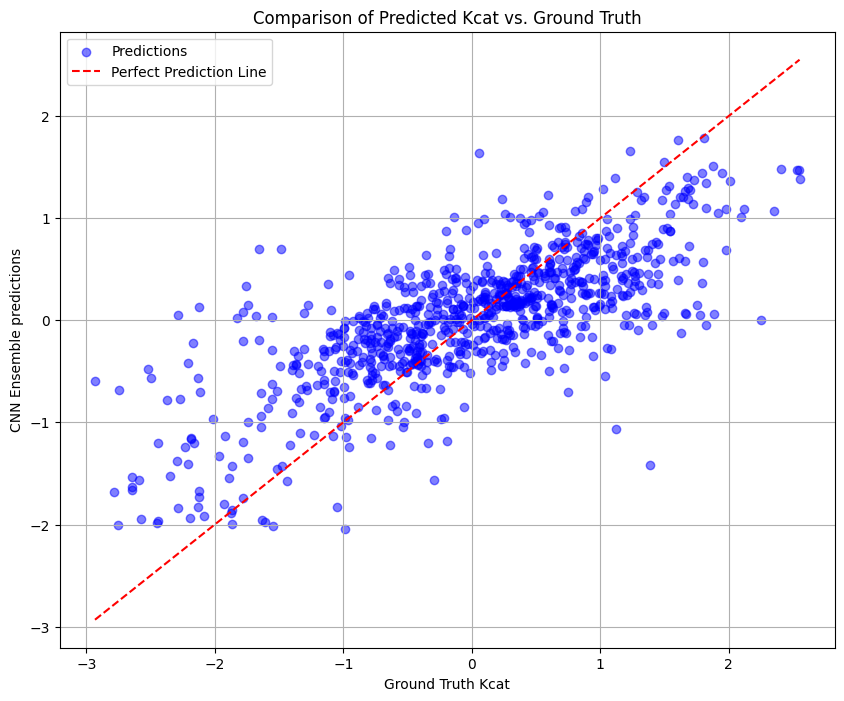

In [6]:
%cd /content/drive/MyDrive/enz-eff-project/data/training_results


import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import numpy as np



def plot_kcat_predictions(test_Y, predictions):
    """
    Plot the graph of ground truth Kcat values against predicted values with enhanced visualization.

    Parameters:
    - test_Y (array-like): Ground truth Kcat values.
    - predictions (array-like): Predicted Kcat values.

    Returns:
    - None
    """
    plt.figure(figsize=(10, 8))
    plt.scatter(test_Y, predictions, alpha=0.5, color='blue', label='Predictions')
    identity_line = np.linspace(min(test_Y), max(test_Y), 100)
    plt.plot(identity_line, identity_line, 'r--', label='Perfect Prediction Line')
    plt.title('Comparison of Predicted Kcat vs. Ground Truth')
    plt.xlabel('Ground Truth Kcat')
    plt.ylabel('CNN Ensemble predictions')
    plt.legend()
    plt.grid(True)
    plt.show()



ensembed_preds_file = "cnn_ensembled_preds.npy"

(
    esm1bts_pred,
    esm1b_pred,
    drfp_pred,
    diff_pred,
    struct_pred, #
    esm_combined,  # 45
    esm1b_struct_new_feats_preds,  # 43
    esm1bts_struct_new_feats_preds,  # 46
    esm1b_drfp_new_feats_preds,  # 46
    esm1bts_drfp_new_feats_preds,  # 47
    esm1b_diff_new_feats_preds,  # 47
    esm1bts_diff_new_feats_preds,  # 49
    esm1b_struct,  # 44
    esm1bts_struct,  # 46
    esm1bts_diff,  # 47
    esm1b_diff,  # 49
    esm1bts_drfp,  # 47
    esm1b_drfp,  # 47

) = np.load(ensembed_preds_file)


combined_preds = np.array(
    [
        esm1bts_pred,
        esm1b_pred,
        drfp_pred,
        diff_pred,
        struct_pred, #
        esm_combined,  # 45
        esm1b_struct_new_feats_preds,  # 43
        esm1bts_struct_new_feats_preds,  # 46
        esm1b_drfp_new_feats_preds,  # 46
        esm1bts_drfp_new_feats_preds,  # 47
        esm1b_diff_new_feats_preds,  # 47
        esm1bts_diff_new_feats_preds,  # 49
        esm1b_struct,  # 44
        esm1bts_struct,  # 46
        esm1bts_diff,  # 47
        esm1b_diff,  # 49
        esm1bts_drfp,  # 47
        esm1b_drfp,  # 47
    ]
)



ground_truth = np.array(list(data_test["log10_kcat_norm"]))  # Ensure your data is loaded correctly
weighted_avg_pred = calculate_weighted_mean(combined_preds, ground_truth)
plot_kcat_predictions(ground_truth, weighted_avg_pred)


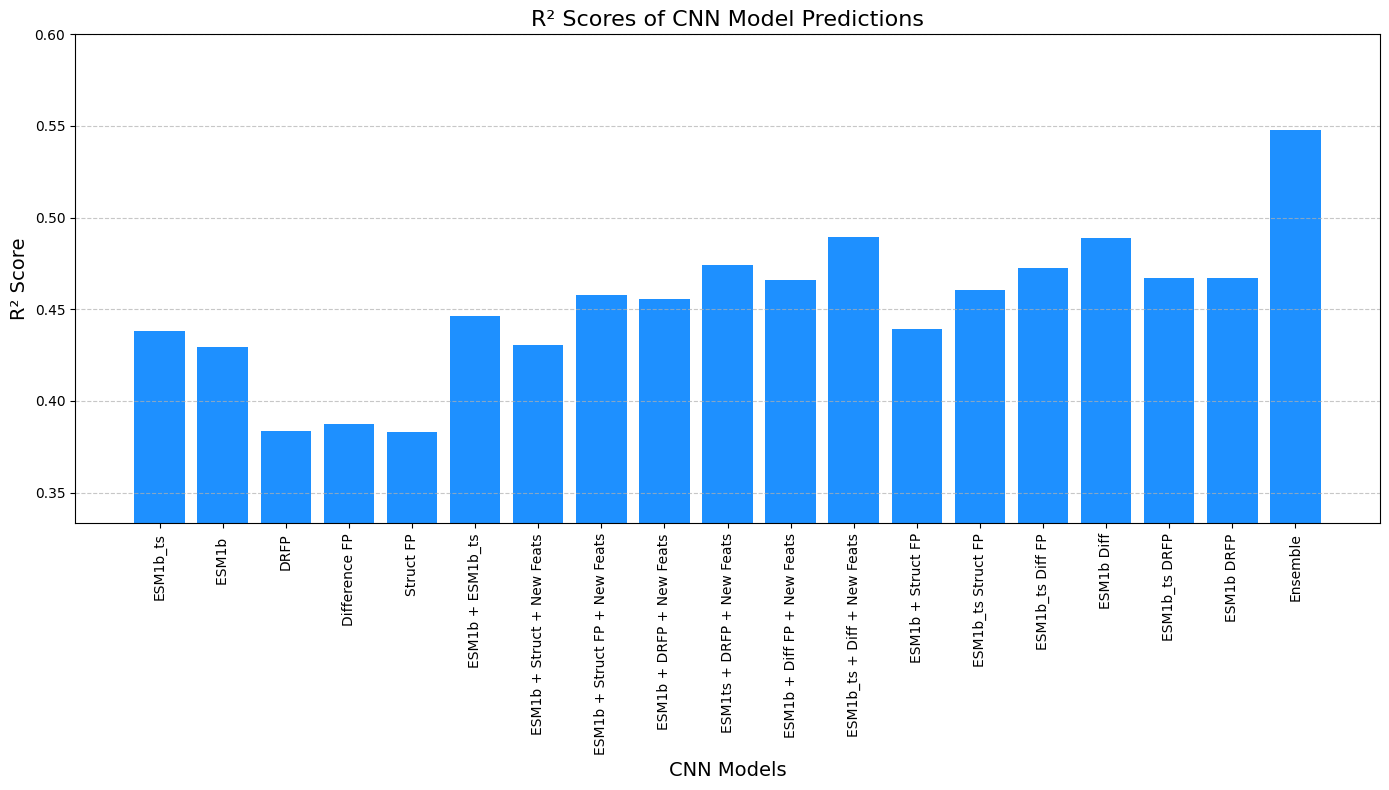

In [ ]:
# Names of the models corresponding to the predictions
model_names = [
    "ESM1b_ts", "ESM1b ", "DRFP", "Difference FP", "Struct FP",
    "ESM1b + ESM1b_ts", "ESM1b + Struct + New Feats", "ESM1b + Struct FP + New Feats",
    "ESM1b + DRFP + New Feats", "ESM1ts + DRFP + New Feats", "ESM1b + Diff FP + New Feats",
    "ESM1b_ts + Diff + New Feats", "ESM1b + Struct FP", "ESM1b_ts Struct FP",
    "ESM1b_ts Diff FP", "ESM1b Diff", "ESM1b_ts DRFP", "ESM1b DRFP", "Ensemble"
]



combined_preds = np.array(
    [
        esm1bts_pred,
        esm1b_pred,
        drfp_pred,
        diff_pred,
        struct_pred,
        esm_combined,
        esm1b_struct_new_feats_preds,
        esm1bts_struct_new_feats_preds,
        esm1b_drfp_new_feats_preds,
        esm1bts_drfp_new_feats_preds,
        esm1b_diff_new_feats_preds,
        esm1bts_diff_new_feats_preds,
        esm1b_struct,
        esm1bts_struct,
        esm1bts_diff,
        esm1b_diff,
        esm1bts_drfp,
        esm1b_drfp,
    ]
)


ground_truth = np.array(list(data_test["log10_kcat_norm"]))
weighted_avg_pred = calculate_weighted_mean(combined_preds, ground_truth)

# Calculate R2 scores for each set of predictions
r2_scores = [r2_score(ground_truth, preds) for preds in combined_preds]
r2_scores.append(r2_score(ground_truth,  weighted_avg_pred))

# Plotting
plt.figure(figsize=(14, 8))
plt.bar(model_names, r2_scores, color='dodgerblue')
plt.xlabel('CNN Models', fontsize=14)
plt.ylabel('R² Score', fontsize=14)
plt.xticks(rotation=90)
plt.title('R² Scores of CNN Model Predictions', fontsize=16)
plt.ylim([min(r2_scores) - 0.05, 0.6])  # Adjust y-axis limits
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


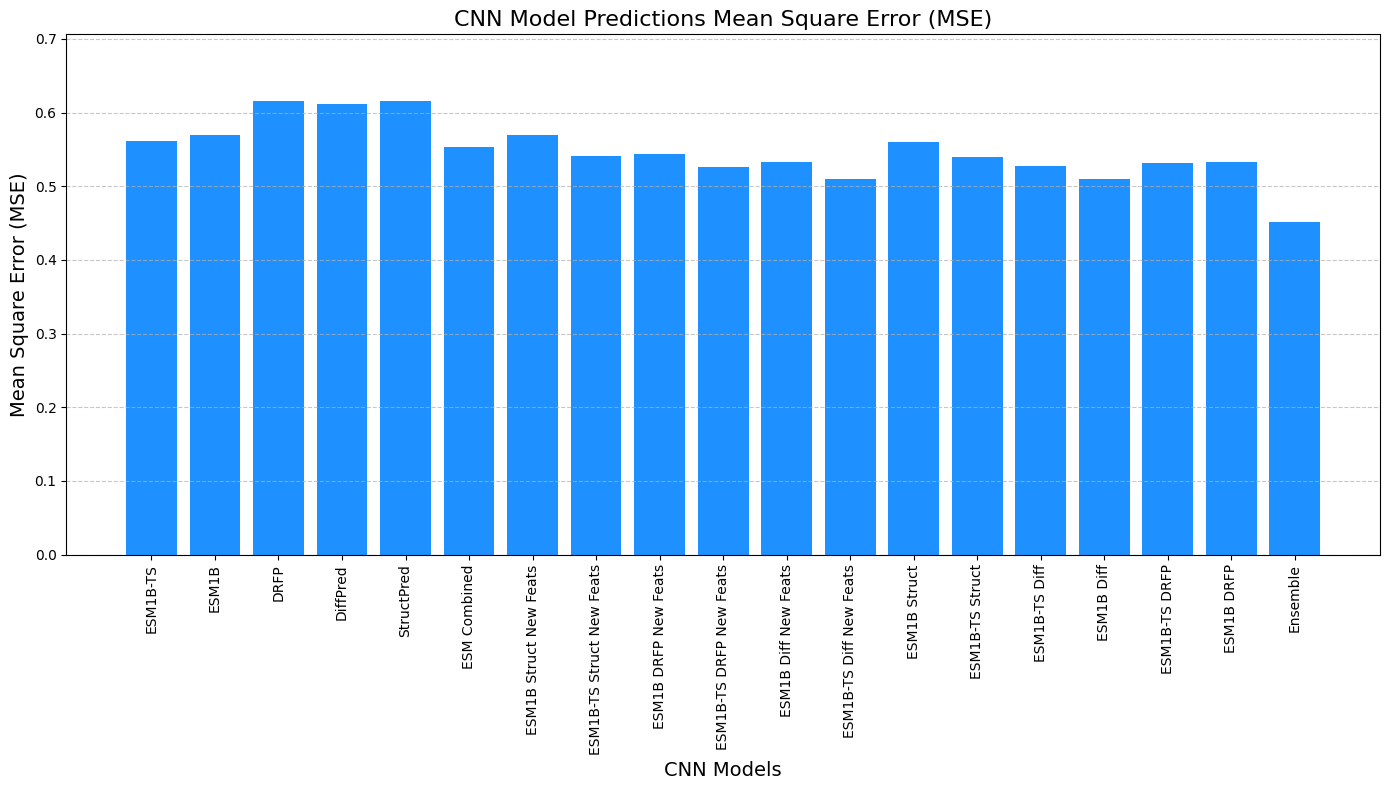

In [ ]:

# Names of the models corresponding to the predictions
model_names = [
    "ESM1B-TS", "ESM1B", "DRFP", "DiffPred", "StructPred",
    "ESM Combined", "ESM1B Struct New Feats", "ESM1B-TS Struct New Feats",
    "ESM1B DRFP New Feats", "ESM1B-TS DRFP New Feats", "ESM1B Diff New Feats",
    "ESM1B-TS Diff New Feats", "ESM1B Struct", "ESM1B-TS Struct",
    "ESM1B-TS Diff", "ESM1B Diff", "ESM1B-TS DRFP", "ESM1B DRFP", "Ensemble"
]


combined_preds = np.array(
    [
        esm1bts_pred,
        esm1b_pred,
        drfp_pred,
        diff_pred,
        struct_pred,
        esm_combined,
        esm1b_struct_new_feats_preds,
        esm1bts_struct_new_feats_preds,
        esm1b_drfp_new_feats_preds,
        esm1bts_drfp_new_feats_preds,
        esm1b_diff_new_feats_preds,
        esm1bts_diff_new_feats_preds,
        esm1b_struct,
        esm1bts_struct,
        esm1bts_diff,
        esm1b_diff,
        esm1bts_drfp,
        esm1b_drfp,
    ]
)


# Calculate MSE for each set of predictions
mse_scores = [mean_squared_error(ground_truth, preds) for preds in combined_preds]

weighted_avg_pred = calculate_weighted_mean(combined_preds, ground_truth)
mse_scores.append(mean_squared_error(ground_truth, weighted_avg_pred))  # Including the ensemble prediction



# Plotting
plt.figure(figsize=(14, 8))
plt.bar(model_names, mse_scores, color='dodgerblue')
plt.xlabel('CNN Models', fontsize=14)
plt.ylabel('Mean Square Error (MSE)', fontsize=14)
plt.xticks(rotation=90)
plt.title('CNN Model Predictions Mean Square Error (MSE)', fontsize=16)
plt.ylim([0, max(mse_scores) + 0.09])  # Adjust y-axis limits to better fit the data
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [8]:
import matplotlib.pyplot as plt
import numpy as np


def plot_kcat_predictions_subplot(test_Y, single_model_predictions, ensemble_predictions):
    """
    Plot subplots of ground truth Kcat values against predicted values with enhanced visualization.

    Parameters:
    - test_Y (array-like): Ground truth Kcat values.
    - single_model_predictions (array-like): Predicted Kcat values of the single best model.
    - ensemble_predictions (array-like): Predicted Kcat values of the ensemble model.

    Returns:
    - None
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Plot for single best model
    axes[0].scatter(test_Y, single_model_predictions, alpha=0.5, color='blue', label='Predictions')
    identity_line = np.linspace(min(test_Y), max(test_Y), 100)
    axes[0].plot(identity_line, identity_line, 'r--', label='Perfect Prediction Line')

    axes[0].set_title('Single Best Model Predicted Kcat vs. Ground Truth')
    axes[0].set_xlabel('Ground Truth Kcat')
    axes[0].set_ylabel('XGBoost Single Best Model Predictions')
    axes[0].legend()
    axes[0].grid(True)

    # Plot for ensemble model
    axes[1].scatter(test_Y, ensemble_predictions, alpha=0.5, color='blue', label='Predictions')
    axes[1].plot(identity_line, identity_line, 'r--', label='Perfect Prediction Line')

    axes[1].set_title('Ensemble Predicted Kcat vs. Ground Truth')
    axes[1].set_xlabel('Ground Truth Kcat')
    axes[1].set_ylabel('XGBoost Ensemble Predictions')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()



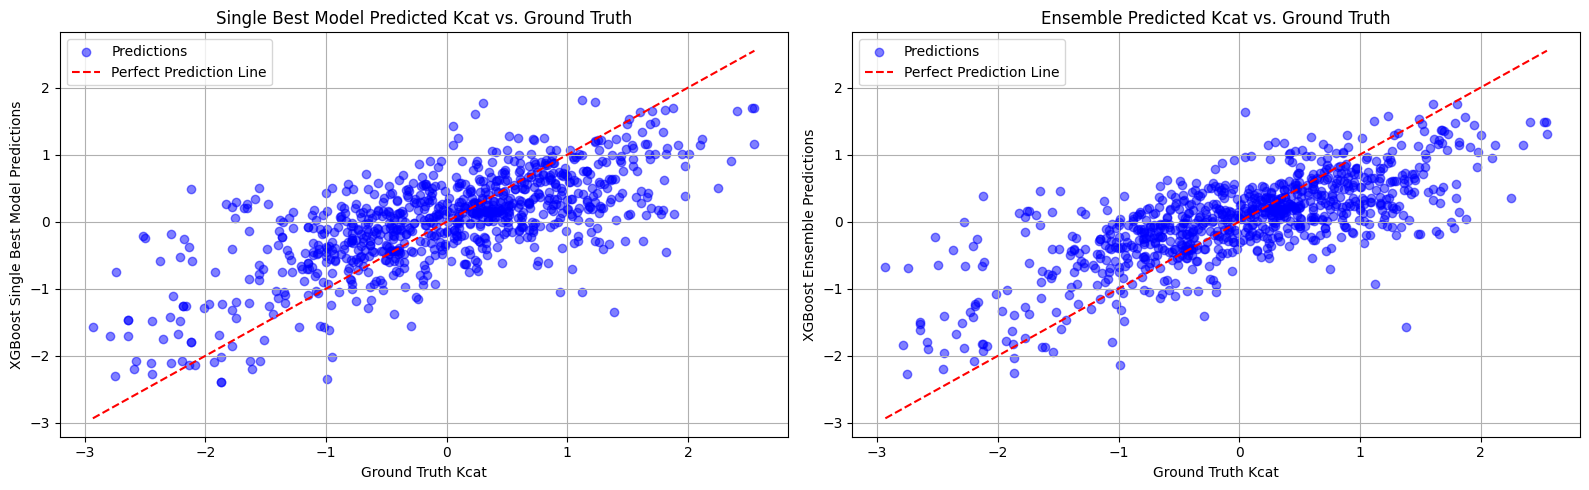

In [9]:
# with previous features only
combined_preds = np.array(
    [
        esm_combined,  # 45
        esm1b_diff,  # 49
        esm1bts_drfp,  # 47
        esm1b_drfp,  # 47
    ]
)



ground_truth = np.array(list(data_test["log10_kcat_norm"]))
weighted_avg_pred = calculate_weighted_mean(combined_preds, ground_truth)
single_model_predictions = esm1b_diff


plot_kcat_predictions_subplot(ground_truth, single_model_predictions, weighted_avg_pred)

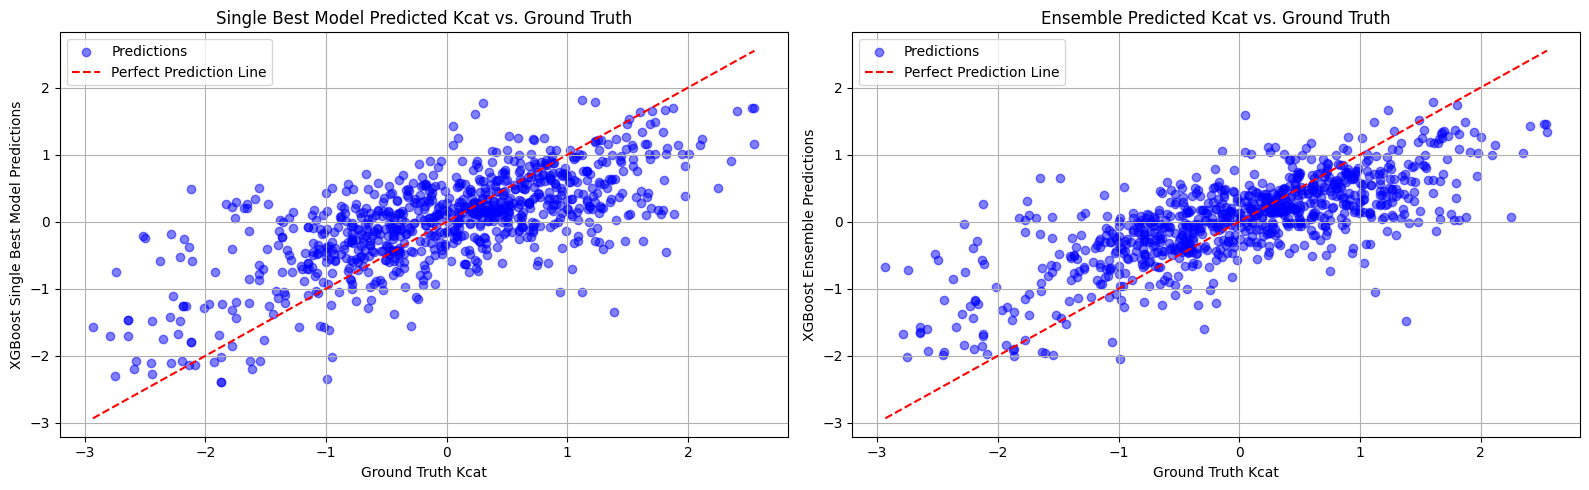

In [10]:
# By combining New features with previous features
combined_preds = np.array(
    [
        esm_combined,  # 45
        esm1b_struct_new_feats_preds,  # 43
        esm1bts_struct_new_feats_preds,  # 46
        esm1bts_drfp_new_feats_preds,  # 47
        esm1bts_diff,  # 47
        esm1b_diff,  # 49
        esm1bts_drfp,  # 47
    ]
)


ground_truth = np.array(list(data_test["log10_kcat_norm"]))
weighted_avg_pred = calculate_weighted_mean(combined_preds, ground_truth)
single_model_predictions = esm1b_diff


plot_kcat_predictions_subplot(ground_truth, single_model_predictions, weighted_avg_pred)